In [1]:
import os

In [3]:
tumor_directory = "/kaggle/input/brain-tumors-dataset/Data/Tumor"


In [4]:
glioma_directory = os.path.join(tumor_directory, 'glioma_tumor')
meningioma_directory = os.path.join(tumor_directory, 'meningioma_tumor')
pituitary_directory = os.path.join(tumor_directory, 'pituitary_tumor')

glioma_files = os.listdir(glioma_directory)
meningioma_files = os.listdir(meningioma_directory)
pituitary_files = os.listdir(pituitary_directory)

num_glioma_files = len(glioma_files)
num_meningioma_files = len(meningioma_files)
num_pituitary_files = len(pituitary_files)

num_glioma_files, num_meningioma_files, num_pituitary_files, glioma_files[:5], meningioma_files[:5], pituitary_files[:5]  # Display the count and first 5 file names in each tumor category

(6307,
 6391,
 5908,
 ['G_264_RO_.jpg',
  'G_658_SP_.jpg',
  'G_299_SP_.jpg',
  'G_331_HF_.jpg',
  'G_360_RO_.jpg'],
 ['M_364_RO_.jpg',
  'M_728_BR_.jpg',
  'M_742_SP_.jpg',
  'M_876_DA_.jpg',
  'M_187.jpg'],
 ['P_665_SP_.jpg',
  'P_476_HF_.jpg',
  'P_638_SP_.jpg',
  'P_121_DA_.jpg',
  'P_175_DA_.jpg'])

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2

image_size = (64, 64)
batch_size = 32

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)
    return images, labels

In [6]:
normal_directory = "/kaggle/input/brain-tumors-dataset/Data/Normal"

In [7]:
normal_images, normal_labels = load_images_from_folder(normal_directory, 0) 
glioma_images, glioma_labels = load_images_from_folder(glioma_directory, 1)
meningioma_images, meningioma_labels = load_images_from_folder(meningioma_directory, 1) 
pituitary_images, pituitary_labels = load_images_from_folder(pituitary_directory, 1) 

In [10]:
all_images = np.array(normal_images + glioma_images[:1000] + meningioma_images[:1000] + pituitary_images[:1000])
all_labels = np.array(normal_labels + glioma_labels[:1000] + meningioma_labels[:1000] + pituitary_labels[:1000])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
X_train, X_test = X_train / 255.0, X_test / 255.0

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=32)

Epoch 1/10
137/137 [==============================] - 12s 80ms/step - loss: 0.5073 - accuracy: 0.7442 - val_loss: 0.3994 - val_accuracy: 0.8765
Epoch 2/10
137/137 [==============================] - 11s 80ms/step - loss: 0.3316 - accuracy: 0.8745 - val_loss: 0.2938 - val_accuracy: 0.9053
Epoch 3/10
137/137 [==============================] - 11s 77ms/step - loss: 0.2437 - accuracy: 0.9159 - val_loss: 0.2471 - val_accuracy: 0.9198
Epoch 4/10
137/137 [==============================] - 10s 77ms/step - loss: 0.1806 - accuracy: 0.9368 - val_loss: 0.2349 - val_accuracy: 0.9321
Epoch 5/10
137/137 [==============================] - 11s 80ms/step - loss: 0.1463 - accuracy: 0.9498 - val_loss: 0.2013 - val_accuracy: 0.9424
Epoch 6/10
137/137 [==============================] - 11s 77ms/step - loss: 0.0996 - accuracy: 0.9643 - val_loss: 0.1937 - val_accuracy: 0.9424
Epoch 7/10
137/137 [==============================] - 11s 77ms/step - loss: 0.0853 - accuracy: 0.9691 - val_loss: 0.2033 - val_accuracy:

In [15]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1

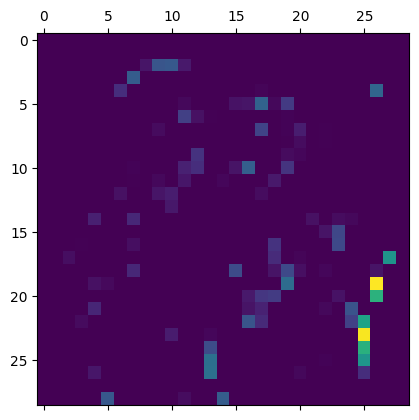

In [18]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_array = X_test[0].reshape((1, 64, 64, 3)) 

#heatmap = make_gradcam_heatmap(img_array, model, 'last_conv_layer_name')  # Replace with the name of the last convolutional layer in your model

heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_1')

plt.matshow(heatmap)
plt.show()